# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
# help(BinaryClassificationPerformance)

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        
        hv = HashingVectorizer(n_features=2**18, alternate_sign=False, stop_words='english', ngram_range=(1, 2),lowercase=True)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        
        transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [5]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=6)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [6]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 5099, 'TN': 4968, 'FP': 5042, 'FN': 4891, 'Accuracy': 0.50335, 'Precision': 0.5028103737304014, 'Recall': 0.5104104104104105, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [7]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [8]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9989, 'TN': 10010, 'FP': 0, 'FN': 1, 'Accuracy': 0.99995, 'Precision': 1.0, 'Recall': 0.9998998998998999, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [10]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [11]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1000000)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9982, 'TN': 10010, 'FP': 0, 'FN': 8, 'Accuracy': 0.9996, 'Precision': 1.0, 'Recall': 0.9991991991991992, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 8017, 'TN': 7227, 'FP': 2783, 'FN': 1973, 'Accuracy': 0.7622, 'Precision': 0.7423148148148148, 'Recall': 0.8025025025025025, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

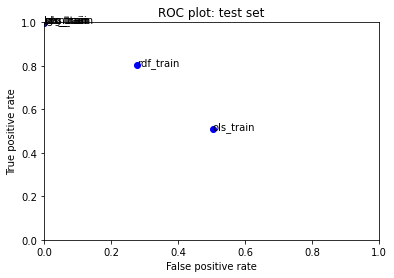

In [13]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [14]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
69
I had a lot of expectations from this movie and more so since it was a Yashraj Film.<br /><br />Jimmy operates a call centre and one day he is invited by Pooja Singh to teach her boss, Lakhan Singh, English. The two fall in love and decide to run away but Pooja tells Jimmy that she can't do this as she owes a debt to Lakhan Singh, who is also known as Bhaiyyaji. But they decide and steal money from him and its only then that Jimmy finds out that Bhaiyyaji / Lakhan Singh is a Don. In the meantime, Bhaiyyaji hires a man, Bachchan Pandey, to track down Jimmy and Pooja.<br /><br />Starring Saif Ali Khan, Kareena Kapoor, Anil Kapoor and Akshaye Kumar, the movie is directed by first time director Viay Krishna Acharya and is produced by both Aditya Chopra and Yash Chopra.<br /><br />\Tashan\" has to be one of the worse films that I have ever watched. Yes! The scenery is good and Kareena Kapoor (and her much publicised weight loss) looks good. But plot is extrem

3926
\Sundown:The Vampire in Retreat\" is a rubbish.The acting is terrible,the atmosphere is non-existent and the characters are uninteresting.The only scary thing about this piece of scum is that majority of the IMDb users gave it a 10.This is really horrifying.No gore,no suspense,no violence,nothing.Bruce Cambell(\"The Evil Dead\",\"Intruder\")is completely wasted,the supporting cast is also terrible.Yes,some people may like this picture,especially a mainstream society but hard-core horror fans or gore-hounds won't enjoy this piece of crap.Personally I hate horror comedies,I prefer watching serious horror movies like \"Cannibal Holocaust\" or \"Last House on the Left\".In my opinion,a real horror movie is supposed to be scary,excessively bloody and disturbing,without stupid humour,which usually ruins the whole concept.This one isn't scary,isn't gory,isn't even funny as a comedy,so don't waste your precious time."
* * * * * * * * * 
3933
I don't know why, but i thought i've seen this 

7945
This film is so ridiculously idiot that you may actually laugh at it. But no, even this is too much for this lost meters of celluloid. I found it as an offer in a magazine and that's why I've seen it. I regret the time I lost to see this. 1 out of 10 (because they don't have a lower grade).
* * * * * * * * * 
7946
The biggest mystery of Veronica Mars is not one that she had to tackle on screen.<br /><br />Rather, the mystery is why this perennial ratings disappointment is still on the air. This week marked a nadir for Veronica Mars: it ranked 146 out of 146 shows in the big 6 (soon to be Big 5). Yes, you read right. Veronica Mars was beaten by every show of the now-defunct WB and every show on UPN. It was beat by all the shows on Fox and of course by all the shows on ABC, CBS and NBC.<br /><br />Now, the hip hypesters are going to say: but this was a re-run. But everything on TV that week was pretty much a re-run! It boggles the mind why CW would choose this proved ratings disappo

11478
Never see this movie.<br /><br />It tries to be a spoof on scifi/thriller films of the 1950s and 1960s but all it succedes at is making you wish really badly that you were watching one of them and not it.<br /><br />It is very lame. A spoof has to have some aspect which has some above par quality to it. This movie does not have any such aspect.<br /><br />Save yourself. It's too late for me but... just don't watch it.
* * * * * * * * * 
11676
I'm the sort of person who went down to the local library and read books on Babbage's difference engine whilst my schoolmates were playing football etc.. So, if there is any such thing as a target audience for this film, then I guess I'd probably be included in that.<br /><br />Maybe I just need to watch it again. A previous reviewer mentioned not to watch this film whilst being tired. Maybe that was my mistake.<br /><br />I tried my best to enjoy this film, and there are aspects of it that I do like, but overall I found it amateurish and qu

14412
My nose is bent slightly out of shape as I write this. I had sent a previous comment on this film some weeks ago that has not yet appeared, so I assume it was rejected, even though it met all the usual guidelines.<br /><br />I found this film interesting for the first thirty minutes, particularly the performance of Jordi Mollà, a veteran actor who has appeared in such major productions as \Blow\" and \"The Alamo.\" Leonor Watling is also quite good. Unfortunately, everything sinks eventually under the weight of a truly awful, melodramatic script. There is also an abundance of gratuitous nudity that does nothing to advance the narrative or lend even an impressionistic nuance to what is otherwise a beautifully filmed piece of art.<br /><br />An actual day trip to the beach at Valencia would be much less arduous than having to encounter these fictional characters again anywhere, anytime."
* * * * * * * * * 
14441
A drama at its very core, \Anna\" displays that genuine truth that all

17204
Would have better strengthened considerably by making it as a<br /><br />50 minute episode of the Outer Limits. Too much superfluous material and stuff like the chief bad guy looking like he'd escaped from The Phantom of the Opera didn't help. The whole 'Night of the Living Dead' sequence was extremely silly and quite unnecessary. After all, if the dead were to punish anyone for their sins, now remind me exactly who was killing everyone again?
* * * * * * * * * 
17414
Without wishing to be a killjoy, Brad Sykes is responsible for at least two of the most dull and clichéd films i've ever seen - this being one of them, and Camp Blood being another. <br /><br />The acting is terrible, the print is shoddy, and everything about this film screams \seriously, you could do better yourself\". Maybe this is a challenge to everyone to saturate youtube with our own zombie related crap?<br /><br />I bought this for £1, but remember, you can't put a price on 71 minutes of your life. You'd do w

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [16]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1244, 'TN': 1227, 'FP': 1263, 'FN': 1266, 'Accuracy': 0.4942, 'Precision': 0.4962106102911847, 'Recall': 0.4956175298804781, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [17]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1970, 'TN': 1947, 'FP': 543, 'FN': 540, 'Accuracy': 0.7834, 'Precision': 0.7839235972940708, 'Recall': 0.7848605577689243, 'desc': 'svm_test'}


### MODEL: logistic regression

In [18]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1983, 'TN': 1949, 'FP': 541, 'FN': 527, 'Accuracy': 0.7864, 'Precision': 0.7856576862123613, 'Recall': 0.7900398406374503, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1857, 'TN': 1540, 'FP': 950, 'FN': 653, 'Accuracy': 0.6794, 'Precision': 0.6615603847524048, 'Recall': 0.7398406374501992, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [20]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2003, 'TN': 1915, 'FP': 575, 'FN': 507, 'Accuracy': 0.7836, 'Precision': 0.7769588828549263, 'Recall': 0.7980079681274901, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2190, 'TN': 2098, 'FP': 392, 'FN': 320, 'Accuracy': 0.8576, 'Precision': 0.8481797056545314, 'Recall': 0.8725099601593626, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [22]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1968, 'TN': 1731, 'FP': 759, 'FN': 542, 'Accuracy': 0.7398, 'Precision': 0.7216721672167217, 'Recall': 0.7840637450199203, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

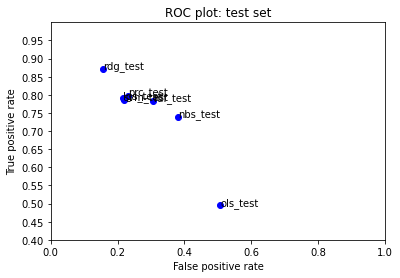

In [23]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [24]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=6, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [25]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49268


In [26]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [27]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1


In [28]:
my_submission.shape

(25000, 2)

In [29]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_first_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation